In [1]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
# NOTE TO PUT UTILITY.PY FILE IN THE SAME FOLDER OF THIS NOTEBOOK
from nutrition_label_utility import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Data and Automated Decision System (ADS)

### College Ranking
CS Rankings (CSR) (https://csrankings.org), with additional attributes from the NRC assessment dataset (http://www.nap.edu/rdp ). This dataset has the following attributes: 
- Average Count (CSR) computes the geometric mean of the adjusted number of publications in each area by institution
- Faculty (CSR) is the number of faculty in the department
- GRE (NRC) is the average GRE scores (2004-2006)
- Department size (CSR) is a binary attribute derived from Faculty. Small department has the number of faculty less or equal than 30.
- Region (NRC) is one of Northeast(NE), Midwest(MW), South Atlantic(SA), South Central(SC), West(W) regions in the US
- Pub Count (NRC) is the average number of publications per faculty (2000-2006)

### Table 1

In [2]:
data = pd.read_csv("CSranking.csv")
data.head(5)

,College Name,Average Count,Faculty,GRE,Department Size,Regional Code,Pub Count
0,Carnegie Mellon University,18.3,122,791.376,Large,NE,2.319
1,Massachusetts Institute of Technology,15.0,64,771.894,Large,NE,2.667
2,Stanford University,14.3,55,800.000,Large,W,4.504
3,University of California--Berkeley,11.4,50,789.451,Large,W,3.198
4,University of Illinois--Urbana-Champaign,10.5,55,771.894,Large,MW,2.704


## ADS - Algorithmic rankers
- Ranking methodology is inspired by US World & News Report and CS Rankings.
- A rule-based system (ranker). Scores are generated through a rule: f(x) = w_1 * Faculty(x) + w_2 * Average Count(x) + w_3 * GRE(x). 
- Generate a ranking of CS departments based on above scores.
- Other possible rankers: [Learning to Rank methods](http://www.morganclaypool.com/doi/abs/10.2200/S00607ED2V01Y201410HLT026)

In [3]:
weights = [1, 1, 1]
chosen_atts = ["Average Count", "Faculty", "GRE"]

data["Score"] = sum([weights[idx]*data[atti] for idx, atti in enumerate(chosen_atts)])
data.head(5)

,College Name,Average Count,Faculty,GRE,Department Size,Regional Code,Pub Count,Score
0,Carnegie Mellon University,18.3,122,791.376,Large,NE,2.319,931.676
1,Massachusetts Institute of Technology,15.0,64,771.894,Large,NE,2.667,850.894
2,Stanford University,14.3,55,800.000,Large,W,4.504,869.300
3,University of California--Berkeley,11.4,50,789.451,Large,W,3.198,850.851
4,University of Illinois--Urbana-Champaign,10.5,55,771.894,Large,MW,2.704,837.394


## 2. Questions considering interpretability
1) (Data) What would be a good feature set for the decisions? 

2) (Outcomes) Is 10.5 a high score or a low score? 
   - The score generation rule alone does not indicate the relative rank of an item. 
   - It depends on how 10.5 compares to the scores of other items.
   
3) (Outcomes) Is the generated scores stable? 
   - Unless raw scores are disclosed, the user has no information about the magnitude of the difference in scores   between items that appear in consecutive ranks. 
   - In Table 1, CMU (18.3) has a much higher score than the immediately following MIT (15). This is in contrast to UIUC (10.5, rank 5) and UW (10.3, rank 6), which are nearly tied.
   
4) (Outcomes) Is there any unfair treatment*?

5) (Outcomes) How are departments represented in the ranking?

6) (Rankers) How to interpret the weight? 
   - The weight of an attribute in the score generation rule does not determine its impact on the outcome.
   - For example, given f(x) = 0.2 * Faculty(x) + 0.3 * Average Count(x) + 0.5 * GRE(x), yet for data in Table 1, attribute Faculty will be the deciding factor that sets apart top-ranked departments from those in lower ranks. 
   - This is because the value of Faculty changes most dramatically in the data, and because it correlates with     Average Count (in effect, double-counting).
    
7) (Rankers) Is the ranking methodology stable? 
   - For example, a score generation rule:  f(x) = Pub Count(x) + GRE(x) would be unstable, because the values of these attributes are both very close for many of the items and induce different rankings.
   - Prioritizing one attribute over the other slightly would cause significant re-shuffling.


## 3. Data Analysis
- Pre-process data set as need.
- Explore the data set before choose the ranker.

### Preprocess data

In [4]:
cur_data = data.iloc[:,:-1] # remove the above generated score column by original data
ignore_atts = ["College Name","Department Size", "Regional Code"] # exclude the categorical data during preprocessing
norm_data = normalizeDataset(cur_data, ignore_atts)
# standarded_data = standardizeData(norm_data, ignore_atts)
norm_data.head(5)

,College Name,Average Count,Faculty,GRE,Department Size,Regional Code,Pub Count
0,Carnegie Mellon University,1.000000,1.000000,0.795577,Large,NE,0.338280
1,Massachusetts Institute of Technology,0.804734,0.462963,0.333776,Large,NE,0.443671
2,Stanford University,0.763314,0.379630,1.000000,Large,W,1.000000
3,University of California--Berkeley,0.591716,0.333333,0.749947,Large,W,0.604482
4,University of Illinois--Urbana-Champaign,0.538462,0.379630,0.333776,Large,MW,0.454876


### Distribution Visualization

In [5]:
def visualize_att_dist(_data, _att, _category=False):
    plt.figure(figsize=[6,5],dpi=100)
    sns.set(style="darkgrid")  
    sns.set(font_scale = 2)
    if _category: # for categorical attribute
        vis_data = _data[_att].value_counts()
        ax = sns.barplot(x=vis_data.index, y=vis_data.values);
        ax.set_yticks([x for x in range(max(vis_data.values)+1) if x%2==0]);
        ax.set_xlabel(_att)
    else:
        ax = sns.distplot(_data[_att], kde=False, color='steelblue');
    ax.set_ylabel("Count")
    plt.tight_layout()

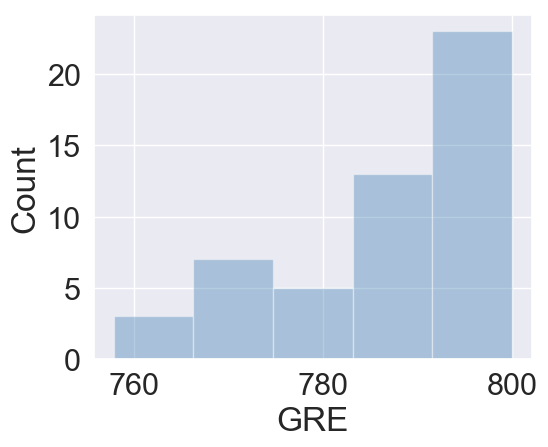

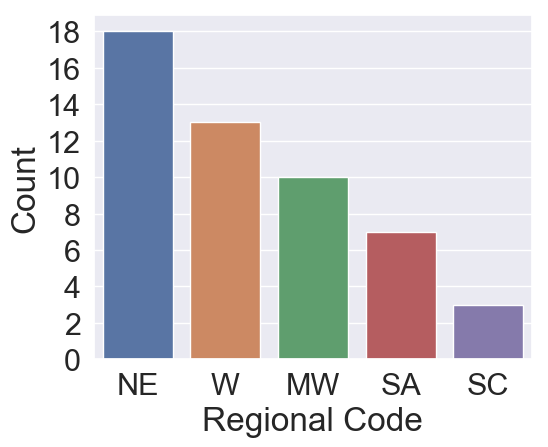

In [6]:
visualize_att_dist(data, "GRE")
visualize_att_dist(data, "Regional Code", _category=True)

### Correlation Visualization

--------------- CORRELATIONS ---------------
               Average Count   Faculty       GRE  Pub Count     Score
Average Count       1.000000  0.864353  0.157443   0.445279  0.835806
Faculty             0.864353  1.000000  0.107261   0.195689  0.890569
GRE                 0.157443  0.107261  1.000000   0.360715  0.541750
Pub Count           0.445279  0.195689  0.360715   1.000000  0.365228
Score               0.835806  0.890569  0.541750   0.365228  1.000000
--------------- CREATE A HEATMAP ---------------


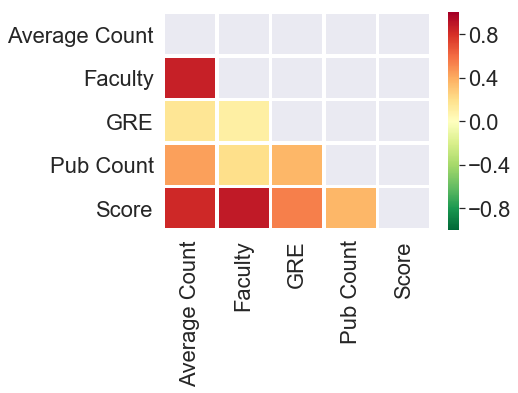

In [7]:
corr_df = data.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
print(corr_df.head(len(data)))
print("--------------- CREATE A HEATMAP ---------------")
# Create a mask to display only the lower triangle of the matrix 
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

## 4. Nutritional Labels
- Web application of Nutritional Labels for Rankings is live at http://demo.dataresponsibly.com/rankingfacts/

- Available tools
   - AI Fairness 360 for fairness validation
   - Data profiling for input data analysis
   - Data cleaning
   - Pyplot and Seaborn for visulizations
   - ...

## Recipe and Ingredients
- These two labels help to explain the ranking methodology. 
- The Recipe label succinctly describes the ranking algorithm. It states the explicit intentions of the designer of the score generation rule about which attributes matter and to what extent.
    - For example, for a linear score generation rule, each attribute would be listed together with its weight. 
- The Ingredients label lists attributes most material to the ranked outcome, in order of importance. 
    - It may show additional attributes associated with high rank. Such associations can be derived with linear models or with other Black-box methods.
    - For example, for a linear model, this list could present the attributes with the highest learned weights. 
- The Recipe and Ingredients labels also list statistics of the attributes in the Recipe and in the Ingredients.
    - minimum, maximum and median values at the top-10 and over-all.

In [8]:
def compute_statistic(_data, _atts):
    """
    Compute the statistics of input attributes.

    Attributes:
        _data: dataframe that stored the data
        _atts: array that stores the attributes to be computed
    Return:  json data of computed statistics
    """
    output_df = pd.DataFrame(columns=["attribute", "median", "mean", "min", "max"])
    for atti in _atts:
        atti_stats = _data.describe().loc[["50%", "mean", "min", "max"], atti].tolist()
        output_df.loc[output_df.shape[0]] = [atti] + atti_stats
    return output_df

### Recipe for top-10 ranking

In [9]:
print("--------------- RANKER USE FOLLOWING ATTRIBUTES ---------------")
print(chosen_atts)
print("--------------- STATISTICALS OF ATTRIBUTES FOR TOP-10 RANKING ---------------")
compute_statistic(data.head(10), chosen_atts)

--------------- RANKER USE FOLLOWING ATTRIBUTES ---------------
['Average Count', 'Faculty', 'GRE']
--------------- STATISTICALS OF ATTRIBUTES FOR TOP-10 RANKING ---------------


,attribute,median,mean,min,max
0,Average Count,10.400,11.0200,6.800,18.3
1,Faculty,55.000,63.4000,45.000,122.0
2,GRE,796.254,791.4109,771.894,800.0


### Recipe for overall ranking

In [10]:
print("--------------- STATISTICALS OF ATTRIBUTES FOR OVERALL RANKING ---------------")
compute_statistic(data, chosen_atts)

--------------- STATISTICALS OF ATTRIBUTES FOR OVERALL RANKING ---------------


,attribute,median,mean,min,max
0,Average Count,2.9,4.447059,1.400,18.3
1,Faculty,32.0,36.470588,14.000,122.0
2,GRE,790.0,787.264255,757.813,800.0


### Ingredients

In [11]:
def linear_correlation(_data, _y_col="Score", top_threshold=0.5, round_default=2):
    """
    Compute the correlation between attributes and generated scores using linear regression.

    Attributes:
        _data: dataframe that stored the data
        _y_col: column name of Y variable
        top_threshold: threshold of attribute coefficient
        round_default: threshold of round function for the returned coefficient
    Return:  list of correlated attributes and its coefficients
    """
    num_atts = list(_data.iloc[:,:-1].describe().columns)
    X = data[num_atts].values
    y = data[_y_col].values

    regr = linear_model.LinearRegression(normalize=False)
    regr.fit(X, y)
    for i in range(len(regr.coef_)):
        regr.coef_[i] = round(regr.coef_[i], round_default)
    # normalize coefficients to [-1,1]
    max_coef = max(regr.coef_)
    min_coef = min(regr.coef_)
    abs_max = max(abs(max_coef),abs(min_coef))
    norm_coef = []
    for ci in regr.coef_:
        new_ci = round(ci/abs_max,round_default)
        norm_coef.append(new_ci)
    coeff_zip = zip(norm_coef, num_atts)
    return_coeff = {}
    for ci, atti in coeff_zip:
        if ci > top_threshold:
            return_coeff[atti] = ci
    return return_coeff

In [12]:
# run the ranker on the normalized data
weights = [0.3, 0.2, 0.5]
chosen_atts = ["Average Count", "Faculty", "GRE"]
data["Score"] = sum([weights[idx]*data[atti] for idx, atti in enumerate(chosen_atts)])
print("--------------- IMPORTANT ATTRIBUTES ---------------")
lg_weights = linear_correlation(data)
lg_weights

--------------- IMPORTANT ATTRIBUTES ---------------


{'Average Count': 0.6, 'GRE': 1.0}

### More details in Ingredients

In [13]:
learned_atts = lg_weights.keys()
print("--------------- STATISTICS OF IMPORTANT ATTRIBUTES for TOP-10 RANKING ---------------")
if len(set(learned_atts).intersection(set(chosen_atts))) != len(chosen_atts):
    print (compute_statistic(data.head(10), learned_atts))
else:
    pass

--------------- STATISTICS OF IMPORTANT ATTRIBUTES for TOP-10 RANKING ---------------
       attribute   median      mean      min    max
0  Average Count   10.400   11.0200    6.800   18.3
1            GRE  796.254  791.4109  771.894  800.0


In [14]:
print("--------------- STATISTICS OF IMPORTANT ATTRIBUTES FOR OVERALL RANKING ---------------")
if len(set(learned_atts).intersection(set(chosen_atts))) != len(chosen_atts):
    print (compute_statistic(data, learned_atts))
else:
    pass

--------------- STATISTICS OF IMPORTANT ATTRIBUTES FOR OVERALL RANKING ---------------
       attribute  median        mean      min    max
0  Average Count     2.9    4.447059    1.400   18.3
1            GRE   790.0  787.264255  757.813  800.0


## Stability
- The Stability label explains whether the ranking methodology is robust on this particular dataset. 
    - An unstable ranking is one where slight changes to the data (e.g., due to uncertainty and noise), or to the methodology (e.g., by slightly adjusting the weights in a score-based ranker) could lead to a significant change in the output. 
- This Stability label reports a stability score, as a single number that indicates the extent of the change required for the ranking to change.
    - The stability of the ranking is quantified as the slope of the line that is fit to the score distribution, at the top-10 and over-all.
    - A score distribution is unstable if scores of items in adjacent ranks are close to each other (|slope| <= 0.25), and so a very small change in scores will lead to a change in the ranking. 

In [15]:
def visualize_stability(_data, _y_col="Score", _top_n=100):
    plt.figure(figsize=[6,5],dpi=100)
    sns.set(style="darkgrid")  
    sns.set(font_scale = 2)
    vis_data = _data.head(_top_n)
    vis_x = [x+1 for x in vis_data.index]
    vis_y = sorted(vis_data[_y_col], reverse=True)
    ax = sns.scatterplot(vis_x, vis_y, color="steelblue");
    ax.set_xlabel("Position")
    ax.set_ylabel(_y_col)
    plt.tight_layout()
def compute_slope_scores(_data, _y_col="Score", round_default=2):
    """
    Compute the slop of a list of scores.

    Attributes:
        _data: file name that stored the data
        _y_col: column name of Y variable
        round_default: threshold of round function for the returned stability
    Return:  slope of scores in the input _data
    """
    xd = [i for i in range(1,len(_data)+1)]
    yd = _data[_y_col].values
    par = np.polyfit(xd, yd, 1, full=True)
    slope = par[0][0]
    return abs(round(slope, round_default))

--------------- UNSTABLE AT TOP 10 (STABILITY AS 0.18) ---------------
--------------- STABLE OVERALL (STABILITY AS 0.35) ---------------


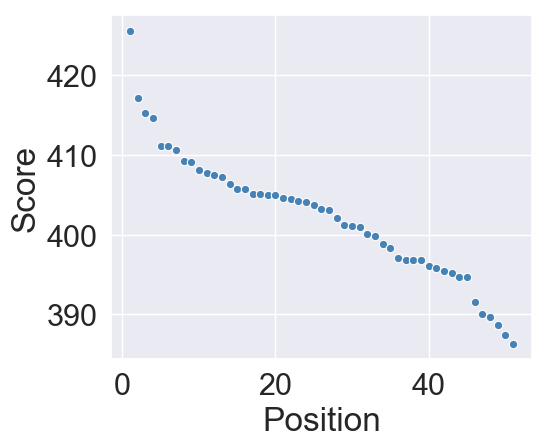

In [16]:
top10_stability = compute_slope_scores(data.head(10))
if top10_stability <= 0.25:
    print("--------------- UNSTABLE AT TOP 10 (STABILITY AS "+str(top10_stability)+") ---------------") 
else:
    print("--------------- STABLE AT TOP 10 (STABILITY AS "+str(top10_stability)+") ---------------") 
all_stability = compute_slope_scores(data)
if all_stability <= 0.25:
    print("--------------- UNSTABLE OVERALL (STABILITY AS "+str(all_stability)+") ---------------") 
else:
    print("--------------- STABLE OVERALL (STABILITY AS "+str(all_stability)+") ---------------")     
visualize_stability(data)

## Fairness
- The Fairness label quantifies whether the ranked output exhibits statistical parity with respect to one or more sensitive attributes, such as gender or race of individuals. 
- All these measures are statistical tests, and whether a result is fair is determined by the computed p-value.
- NULL hypothesis is that ranking process is fair for protected group.
- The results fo three measures of statistical parity are shown: [FA*IR](https://dl.acm.org/citation.cfm?doid=3132847.3132938), [proportion](https://doi.org/10.1007/s10618-017-0506-1), and [pairwise comparison](https://arxiv.org/pdf/1804.07890.pdf).
- A ranking is considered unfair when the p-value of the corresponding statistical test falls below 0.05 or based on the adjusted alpha for FA*IR.

### FA* IR measure

In [17]:
def compute_p_FAIR(_data, _att, _protected_group, _y_col="Score", top_k = 100, round_default = 2):
    """
    Compute p-value using FA*IR algorithm

    Attributes:
        _data: dataframe that stored the data
        _att: sensitive attribute name
        _protected_group: the value of sensitive attribute for protected group
        _y_col: the column that stores the values of ranking
        top_k: the top ranking to verify group fairness
        round_default: threshold of round function
    Return:  rounded p-value and adjusted significance level in FA*IR
    """
    _data.sort_values(by=_y_col, ascending=False, inplace=True)
    _data.reset_index(drop=True, inplace=True)
    if len(_data)/2 < top_k:
        top_k = int(len(_data)/2)
    pos_protected = _data[_data[_att]==_protected_group].index+1
    pro_prob = len(pos_protected)/len(_data)

    # transform ranking to a ranking of tuples with (id,"pro")/(id,"unpro") to run FA*IR
    transformed_ranking = []
    for index, row in _data.head(top_k).iterrows():
        if row[_att] == _protected_group:
            transformed_ranking.append([index,"pro"])
        else:
            transformed_ranking.append([index,"unpro"])

    p_value, isFair, posiFail, alpha_c, pro_needed_list = computeFairRankingProbability(top_k, pro_prob, transformed_ranking)
    return p_value, isFair, posiFail, round(alpha_c,round_default)

In [18]:
sensi_att = "Department Size"
protected_groups = data[sensi_att].unique()
print("--------------- GROUP FAIRNESS VERIFICATION CONSIDERING "+sensi_att+" ---------------") 
for vi in protected_groups:
    vi_p, fair_res, pos_fail, vi_alpha = compute_p_FAIR(data, sensi_att, vi)
    if fair_res:
        print("--------------- FAIR FOR "+vi+" (p="+str(vi_p)+", alpha="+str(vi_alpha)+") ---------------") 
    else:
        print("--------------- UNFAIR FOR "+vi+" (p="+str(vi_p)+", alpha="+str(vi_alpha)+") FAIL AT RANK POSITION "+str(pos_fail)+" ---------") 

--------------- GROUP FAIRNESS VERIFICATION CONSIDERING Department Size ---------------
--------------- FAIR FOR Large (p=0.9860885630366442, alpha=0.87) ---------------
--------------- UNFAIR FOR Small (p=0.038976119236976886, alpha=0.65) FAIL AT RANK POSITION 5 ---------


### Pairwise comparison

In [19]:
def compute_p_pairs(_data, _att, _protected_group, _y_col="Score", run_time = 100, round_default = 2):
    """
    Compute p-value using Pairwise oracle

    Attributes:
        _data: dataframe that stored the data
        _att: sensitive attribute name
        _protected_group: the value of sensitive attribute for protected group
        _y_col: the column that stores the values of ranking
        run_time: simulation times for pairwise comparison
        round_default: threshold of round function
    Return:  rounded p-value
    """
    _data.sort_values(by=_y_col, ascending=False, inplace=True)
    _data.reset_index(drop=True, inplace=True)
    pos_protected = _data[_data[_att]==_protected_group].index+1
    pro_prob = len(pos_protected)/len(_data)
    total_n = len(_data)
    pro_n = len(pos_protected)
    seed_random_ranking = [x for x in range(total_n)]  # list of IDs
    seed_f_index = [x for x in range(pro_n)]  # list of IDs
    
    sim_df = pd.DataFrame(columns=["Run", "pair_n"])
    # run the simulation of ranking generation, in each simulation, generate a fair ranking with input N and size of sensitive group
    for ri in range(run_time):
        output_ranking = mergeUnfairRanking(seed_random_ranking, seed_f_index, pro_prob)
        position_pro_list = [i for i in range(total_n) if output_ranking[i] in seed_f_index]
        count_sensi_prefered_pairs = 0
        for i in range(len(position_pro_list)):
            cur_position = position_pro_list[i]
            left_sensi = pro_n - (i + 1)
            count_sensi_prefered_pairs = count_sensi_prefered_pairs + (total_n - cur_position - left_sensi)
        cur_row = [ri + 1, count_sensi_prefered_pairs]
        sim_df.loc[sim_df.shape[0]] = cur_row

    input_pair_n, _, _ = computePairN(_att, _protected_group, _data)
    pair_samples = list(sim_df["pair_n"].dropna())
    return round(Cdf(pair_samples, input_pair_n), round_default)

In [20]:
sensi_att = "Department Size"
protected_groups = data[sensi_att].unique()
print("--------------- GROUP FAIRNESS VERIFICATION CONSIDERING "+sensi_att+" ---------------") 
for vi in protected_groups:
    vi_p = compute_p_pairs(data, sensi_att, vi)
    if vi_p > 0.05:
        print("--------------- FAIR FOR "+vi+" (p="+str(vi_p)+", alpha=0.05) ---------------") 
    else:
        print("--------------- UNFAIR FOR "+vi+" (p="+str(vi_p)+", alpha=0.05) --------------") 

--------------- GROUP FAIRNESS VERIFICATION CONSIDERING Department Size ---------------
--------------- FAIR FOR Large (p=0.96, alpha=0.05) ---------------
--------------- UNFAIR FOR Small (p=0.04, alpha=0.05) --------------


### Proportion

In [21]:
def compute_p_proportion(_data, _att, _protected_group, _y_col="Score", top_k = 100, round_default = 2):
    """
    Compute p-value using Proportion oracle, i.e., z-test method of 4.1.3 in "A survey on measuring indirect discrimination in machine learning".

    Attributes:
        _data: dataframe that stored the data
        _att: sensitive attribute name
        _protected_group: the value of sensitive attribute for protected group
        _y_col: the column that stores the values of ranking
        top_k: the top ranking to verify group fairness
        round_default: threshold of round function
    Return:  rounded p-value
    """
    
    _data.sort_values(by=_y_col, ascending=False, inplace=True)
    _data.reset_index(drop=True, inplace=True)
    if len(_data)/2 < top_k:
        top_k = int(len(_data)/2)
    total_n = len(_data)
    pro_n = len(_data[_data[_att]==_protected_group])
    unpro_n = total_n - pro_n
    
    top_data = _data.head(top_k)
    pro_k = len(top_data[top_data[_att]==_protected_group])
    unpro_k = top_k - pro_k
    

    pooledSE = math.sqrt((pro_k / pro_n * (1-pro_k/pro_n) / pro_n) + (unpro_k/unpro_n * (1-unpro_k/unpro_n) / unpro_n))
    
    z_test = (unpro_k/unpro_n - pro_k/pro_n) / pooledSE
    p_value = norm.sf(z_test)

    return round(p_value,round_default)

In [22]:
sensi_att = "Department Size"
protected_groups = data[sensi_att].unique()
print("--------------- GROUP FAIRNESS VERIFICATION CONSIDERING "+sensi_att+" ---------------") 
for vi in protected_groups:
    vi_p = compute_p_proportion(data, sensi_att, vi)
    if vi_p > 0.05:
        print("--------------- FAIR FOR "+vi+" (p="+str(vi_p)+", alpha=0.05) ---------------") 
    else:
        print("--------------- UNFAIR FOR "+vi+" (p="+str(vi_p)+", alpha=0.05) --------------") 

--------------- GROUP FAIRNESS VERIFICATION CONSIDERING Department Size ---------------
--------------- FAIR FOR Large (p=1.0, alpha=0.05) ---------------
--------------- UNFAIR FOR Small (p=0.0, alpha=0.05) --------------


## Diversity
- The Diversity label shows diversity with respect to a set of demographic categories of individuals, or a set of categorical attributes of other kinds of items. 
- This label displays the proportion of each category in the top-10 ranked list and over-all.
- Like other labels, it is updated as the user selects different ranking methods or sets different weights. 

In [23]:
def visualize_diversity(_data, _att, _y_col="Score"):
    plt.figure(figsize=[6,5],dpi=100)
    sns.set(font_scale = 2)
    sns.set_palette(palette="pastel")
    sort_data = _data.sort_values(by=_y_col, ascending=False)
    vis_count = sort_data[_att].value_counts()
    plt.pie(list(vis_count.values), labels=list(vis_count.index));
    plt.title(_att)
    plt.tight_layout()

### Diversity for top-10 ranking

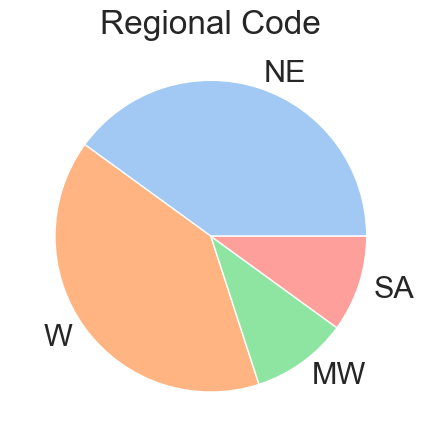

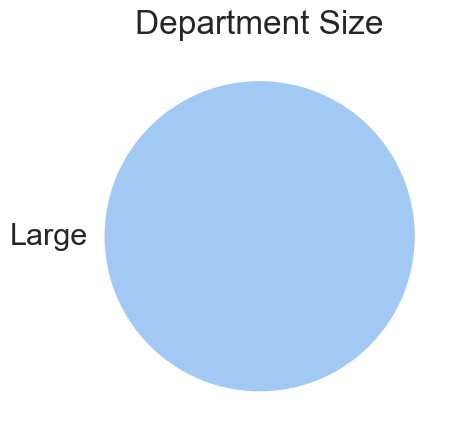

In [24]:
chosen_atts = ["Regional Code", "Department Size"]
for atti in chosen_atts:
    visualize_diversity(data.head(10), atti)

### Diversity for overall ranking

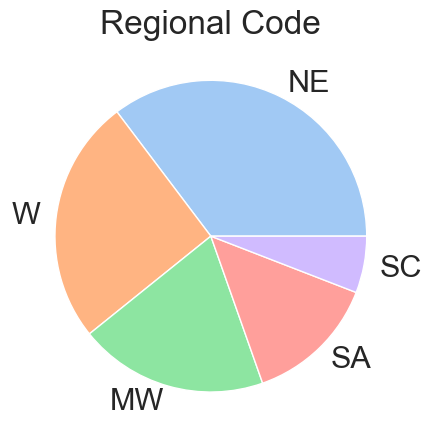

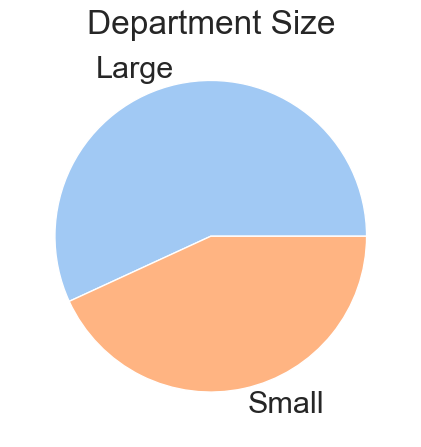

In [25]:
for atti in chosen_atts:
    visualize_diversity(data, atti)